In [ ]:
!nvidia-smi

Sun Apr  7 11:54:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
import torch.nn as nn  # 신경망 모듈, 구축 및 훈련에 사용
from torch.utils.data.dataset import Dataset # 사용자 정의 데이터 셋을 만들어 딥러닝을 할 수 있게 함
import torchvision
import torchvision.transforms as transforms # 이미지 전처리에 필요한 transform 사용
from torch.utils.data import DataLoader # 데이터 관리에 필요한 dataloader
import torch.nn.functional as F # loss or cost gradient와 같은 여러 함수를 사용할 수 있음
from sklearn.metrics import f1_score, confusion_matrix # f1 score와 행렬을 계산 -> 모델의 성능 평가
import numpy as np # numpy 사용
import matplotlib.pyplot as plt #시각화를 위한 차트 사용
from torch.cuda import is_available
from torchvision.datasets import CIFAR10

In [ ]:
device='cuda' if is_available() else 'cpu'
lr = 1e-4
batch_size=32
epoch = 10

In [ ]:
all_data=CIFAR10(root='.',train=True,transform=transforms.ToTensor(),download=True)

meanRGB=[np.mean(x.numpy(),axis=(1,2)) for x,_ in all_data]
stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in all_data]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print('Mean:',meanR, meanG, meanB)
print('Std:',stdR, stdG, stdB)
mean = [meanR, meanG, meanB]
std = [stdR, stdG, stdB]

100%|██████████| 170498071/170498071 [00:02<00:00, 79835704.78it/s]


Extracting ./cifar-10-python.tar.gz to .
Mean: 0.49139965 0.48215845 0.4465309
Std: 0.20220213 0.19931543 0.20086348


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(227),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

In [ ]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 75331874.76it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 64, kernel_size=3, padding=1), # conv1
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(64,64,kernel_size=3, padding=1),# conv2
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),  # conv3
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(128, 128, kernel_size=3, padding=1),  # conv4
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # maxpool2
        )

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=3, padding=1),  # conv3 수정
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(128, 128, kernel_size=3, padding=1),  # conv4
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # maxpool2
        )

        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, padding=1),  # conv5
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),  # conv6
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # maxpool3
        )

        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 512, kernel_size=3, padding=1),  # conv7
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(512, 512, kernel_size=3, padding=1),  # conv8
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)  # maxpool4
        )

        self.avgpool = torch.nn.AdaptiveAvgPool2d((6,6))

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(6 * 6 * 512, 4096),  # fc1
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),  # fc2
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, num_classes)  # fc3
        )


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
model = Net(in_channels = 3, num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
from tqdm import tqdm

def train(model, train_loader, optimizer, Epoch):
    model.train()
    losses = []
    correct = 0
    total_samples = len(train_loader.dataset)

    with tqdm(total=len(train_loader), unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {Epoch+1}")
        for batch_idx, (image, label) in enumerate(train_loader):
            image = image.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(image)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            tepoch.set_postfix(loss=f"{loss.item():.4f}")
            tepoch.update(1)

    train_loss = np.mean(losses)
    accuracy = 100. * correct / total_samples

    return train_loss, accuracy


In [ ]:
def evaluate(model, test_loader):
    model.eval()
    losses = []
    correct = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            loss = criterion(output, label)
            losses.append(loss.item())

            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss = np.mean(losses)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [11]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for Epoch in range(11):
    train_loss, train_accuracy = train(model, trainloader, optimizer, Epoch)
    test_loss, test_accuracy = evaluate(model, testloader)

    # 각 에폭별로 훈련 손실과 정확도, 테스트 손실과 정확도를 저장
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"\n[EPOCH: {Epoch+1}]\tTrain Loss: {train_loss:.4f}\tTrain Accuracy: {train_accuracy} %")
    print(f"[EPOCH: {Epoch+1}]\tTest Loss: {test_loss:.4f}\tTest Accuracy: {test_accuracy} % \n")

Epoch 1: 100%|██████████| 1563/1563 [09:02<00:00,  2.88batch/s, loss=0.9124]



[EPOCH: 1]	Train Loss: 1.6149	Train Accuracy: 40.206 %
[EPOCH: 1]	Test Loss: 1.2185	Test Accuracy: 56.32 % 



Epoch 2: 100%|██████████| 1563/1563 [09:02<00:00,  2.88batch/s, loss=0.8907]



[EPOCH: 2]	Train Loss: 1.0448	Train Accuracy: 63.222 %
[EPOCH: 2]	Test Loss: 0.8871	Test Accuracy: 69.26 % 



Epoch 3: 100%|██████████| 1563/1563 [09:02<00:00,  2.88batch/s, loss=0.5270]



[EPOCH: 3]	Train Loss: 0.7738	Train Accuracy: 73.082 %
[EPOCH: 3]	Test Loss: 0.7002	Test Accuracy: 75.43 % 



Epoch 4: 100%|██████████| 1563/1563 [09:01<00:00,  2.88batch/s, loss=0.2444]



[EPOCH: 4]	Train Loss: 0.6231	Train Accuracy: 78.47 %
[EPOCH: 4]	Test Loss: 0.6246	Test Accuracy: 78.74 % 



Epoch 5: 100%|██████████| 1563/1563 [09:02<00:00,  2.88batch/s, loss=0.2989]



[EPOCH: 5]	Train Loss: 0.5189	Train Accuracy: 82.2 %
[EPOCH: 5]	Test Loss: 0.5461	Test Accuracy: 81.18 % 



Epoch 6: 100%|██████████| 1563/1563 [09:03<00:00,  2.87batch/s, loss=0.8540]



[EPOCH: 6]	Train Loss: 0.4315	Train Accuracy: 85.236 %
[EPOCH: 6]	Test Loss: 0.5086	Test Accuracy: 82.6 % 



Epoch 7: 100%|██████████| 1563/1563 [09:03<00:00,  2.87batch/s, loss=0.1892]



[EPOCH: 7]	Train Loss: 0.3636	Train Accuracy: 87.586 %
[EPOCH: 7]	Test Loss: 0.5039	Test Accuracy: 83.11 % 



Epoch 8: 100%|██████████| 1563/1563 [09:04<00:00,  2.87batch/s, loss=0.2232]



[EPOCH: 8]	Train Loss: 0.3000	Train Accuracy: 89.768 %
[EPOCH: 8]	Test Loss: 0.5013	Test Accuracy: 83.79 % 



Epoch 9: 100%|██████████| 1563/1563 [09:02<00:00,  2.88batch/s, loss=0.1339]



[EPOCH: 9]	Train Loss: 0.2538	Train Accuracy: 91.27 %
[EPOCH: 9]	Test Loss: 0.5066	Test Accuracy: 84.59 % 



Epoch 10: 100%|██████████| 1563/1563 [09:03<00:00,  2.88batch/s, loss=0.2170]



[EPOCH: 10]	Train Loss: 0.2086	Train Accuracy: 92.99 %
[EPOCH: 10]	Test Loss: 0.5247	Test Accuracy: 84.47 % 



Epoch 11: 100%|██████████| 1563/1563 [09:03<00:00,  2.88batch/s, loss=0.0326]



[EPOCH: 11]	Train Loss: 0.1734	Train Accuracy: 94.204 %
[EPOCH: 11]	Test Loss: 0.5207	Test Accuracy: 84.38 % 



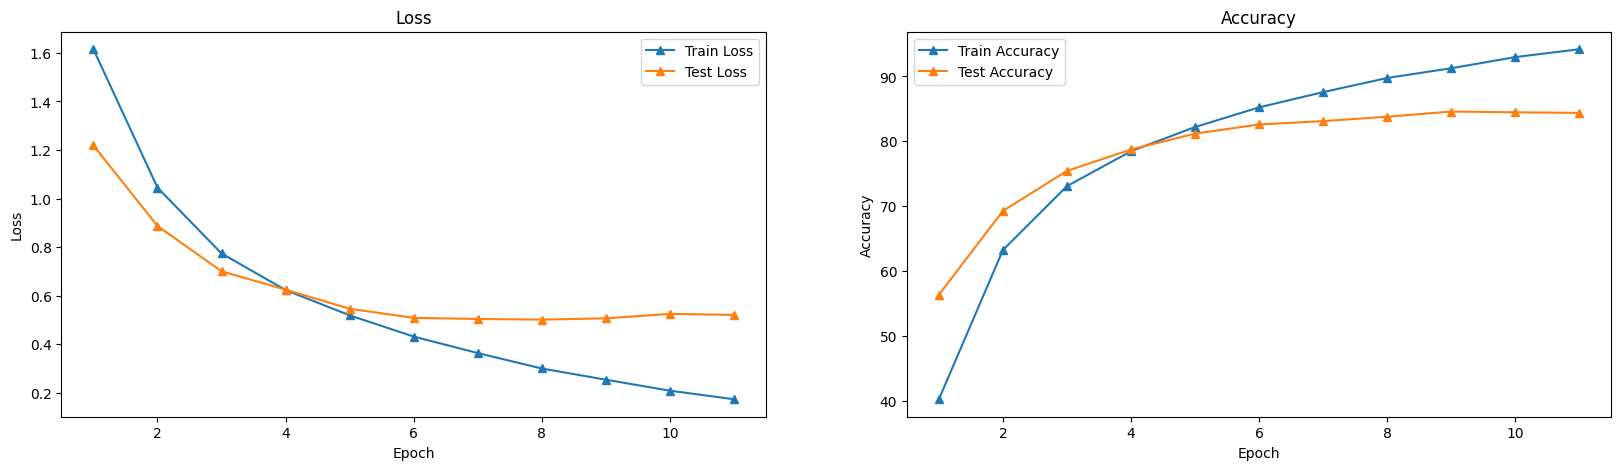

In [12]:
plt.figure(figsize=(20, 5))
epochs = range(1, 12)
# 첫 번째 그래프
plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째 그래프
plt.plot(epochs, train_losses, label='Train Loss',marker='^')
plt.plot(epochs, test_losses, label='Test Loss',marker='^')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 두 번째 그래프
plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째 그래프
plt.plot(epochs, train_accuracies, label='Train Accuracy',marker='^')
plt.plot(epochs, test_accuracies, label='Test Accuracy',marker='^')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()